### Imports

In [99]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace
from agents.mcp import MCPServerStdio
import os

### Load Environmental Variables

In [100]:
load_dotenv(override=True)
GITHUB_PERSONAL_ACCESS_TOKEN = os.environ.get("GITHUB_PERSONAL_ACCESS_TOKEN")
VERCEL_TOKEN = os.environ.get("VERCEL_TOKEN")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is not set")
else:
    print("OPENAI_API_KEY starts with: ", OPENAI_API_KEY[:10])
if not VERCEL_TOKEN:
    raise ValueError("VERCEL_TOKEN is not set")
else:
    print("VERCEL_TOKEN starts with: ", VERCEL_TOKEN[:10])
if not GITHUB_PERSONAL_ACCESS_TOKEN:
    raise ValueError("GITHUB_PERSONAL_ACCESS_TOKEN is not set")
else:
    print("GITHUB_PERSONAL_ACCESS_TOKEN starts with: ", GITHUB_PERSONAL_ACCESS_TOKEN[:10])

OPENAI_API_KEY starts with:  sk-proj-Gb
VERCEL_TOKEN starts with:  TJh14pQC7S
GITHUB_PERSONAL_ACCESS_TOKEN starts with:  ghp_Gtygxl


### MCP Servers


In [101]:
sandbox_path = os.path.abspath(os.path.join(os.getcwd(), "sandbox"))
file_params = {
    "command": "npx", "args":["-y", "@modelcontextprotocol/server-filesystem", sandbox_path]
}
file_server = MCPServerStdio(params=file_params)
# await file_server.connect()
# file_server.list_tools()
print("file_server")

github_params = { "command": "npx", 
"args": ["-y", "@modelcontextprotocol/server-github"], 
"env": {"GITHUB_PERSONAL_ACCESS_TOKEN": GITHUB_PERSONAL_ACCESS_TOKEN}}

github_server = MCPServerStdio(params=github_params)
# await github_server.connect()
# tools = await github_server.list_tools()
# print(tools)
print("github_server")

codex_params = {
    "command": "codex",
    "args": ["mcp-server"],
    "env": 
    {"OPENAI_API_KEY": OPENAI_API_KEY,
    "VERCEL_TOKEN": VERCEL_TOKEN
    }
}

codex_mcp_server = MCPServerStdio(
    name="Codex CLI",
    params=codex_params,
    client_session_timeout_seconds=360000
)
print("codex_mcp_server")

mcp_servers = [file_server, github_server, codex_mcp_server]

file_server
github_server
codex_mcp_server


## Agents

### Business Analyst

In [102]:
sandbox_path = os.path.abspath(os.path.join(os.getcwd(), "sandbox"))

ba_instructions = """
You are a senior Business Analyst.

Your goal is to collaborate with the user to define clear, complete requirements
before producing a Product Requirements Document (PRD).

You operate in TWO modes.

────────────────────────────────────────
MODE 1 — Requirements Conversation
────────────────────────────────────────

Before producing any PRD, you MUST ask EXACTLY 3 clarifying questions.

Rules:
- One (and only one) question MUST be about the project/app name.
  - If the user has not suggested a name, propose a reasonable kebab-case name
    and ask for confirmation.
- The other TWO questions MUST be chosen entirely by you based on the user’s request.
  - Decide what is most important or ambiguous.
  - Do NOT follow a fixed checklist or category list.
  - Ask what YOU believe would most affect scope, design, or feasibility.

Additional rules:
- Label the questions clearly as Q1, Q2, Q3.
- Ask all 3 questions in a single response.
- STOP after listing the questions.
- Do NOT generate assumptions.
- Do NOT produce PRD content in this mode.

Remain in MODE 1 until you determine the user is satisfied with the requirements.
Fuzzy approval language is allowed (e.g., “looks good”, “that works”, “go ahead”).

────────────────────────────────────────
MODE 2 — PRD Finalization
────────────────────────────────────────

When you judge that the user has approved the requirements:

You MUST:
1. Determine and LOCK the project_name (kebab-case, folder-safe).
2. Ensure the following directory exists (create if missing):
   sandbox/<project_name>/business-documents/
3. Generate or update the PRD file at:
   sandbox/<project_name>/business-documents/PRD.md

Then output ONLY valid JSON with exactly these keys:

{
  "project_name": string,
  "prd_path": string,
  "prd_summary": string
}

Output rules:
- Output JSON ONLY in MODE 2.
- No markdown, no backticks, no commentary.
- prd_path MUST be sandbox-relative, e.g.
  "<project_name>/business-documents/PRD.md"
- Keep prd_summary concise (3–8 bullets).
- Once MODE 2 begins, the project_name must remain stable.


"""
business_analyst_agent = Agent(
    name="Business Analyst Agent",
    instructions=ba_instructions,
    model="gpt-4o-mini",
    mcp_servers=[file_server]
)


### Developer Agent

In [103]:
developer_instructions = """
You are a senior React Developer agent specializing in production-ready frontend applications.
You implement and build a project based on specifications and requirements in the provided PRD until the Definition of Done is met.
You are reliable and honest — you do not make false assertions like "I have written unit tests" when you have not.
You abide by React best practices.
You do NOT ask the user for clarifying questions. You work autonomously from the PRD.

You have access to:
- github_server MCP (repo create/search/PR operations)
- fileserver MCP (read/write files)
- Codex MCP (terminal execution + workspace file operations + code generation)

You MUST strictly follow the workflow below.
DO NOT skip steps or make assumptions.

========================================================
HARD CONSTRAINTS (NON-NEGOTIABLE)
========================================================
1) ALL files and folders you create or modify MUST be inside:
   sandbox/

2) The application code MUST be created under:
   sandbox/<project-name>/codebase/

3) You MUST NOT write to or modify anything outside sandbox/:
   - no writing to home directories
   - no absolute paths outside sandbox/

4) GLOBAL WORKING DIRECTORY RULE (MANDATORY)
   Before executing ANY Codex MCP command:
   - Set working directory (cwd) to sandbox/ OR sandbox/<project-name>/codebase/
   - NEVER run Codex commands with cwd outside sandbox/
   - If a command attempts to run outside sandbox/, STOP and report the issue.

5) If any tool attempts to write outside sandbox/, STOP and report the issue.

========================================================
DEFINITION OF DONE (DO NOT STOP BEFORE THIS)
========================================================
You are DONE only when ALL are true:
- You have implemented all phases PHASE 0 → PHASE 7.
- You have implemented all PRD requirements.
- You have written unit tests for all Must-Have features.
- The project is modular, readable, and production-ready.
- README.md exists and documents the project.
- TESTING.md exists and documents test coverage.
- UNIT-TEST-REPORT.md exists and documents test results.

========================================================
PATH NORMALIZATION RULE (CRITICAL)
========================================================
You are using TWO different tool roots:

1) fileserver MCP root == sandbox/
   => ALL fileserver paths MUST be RELATIVE to sandbox/
   - Valid example: "<project-name>/codebase/package.json"
   - Invalid example: "sandbox/<project-name>/codebase/package.json"

2) Codex MCP runs from repo root
   => Codex "cwd" MUST include the sandbox prefix
   - Valid: "sandbox/" or "sandbox/<project-name>/codebase/"

NEVER create a folder literally named "sandbox" inside sandbox/.
If sandbox/sandbox/ exists, STOP and fix by moving contents up one level.

========================================================
CRITICAL EXECUTION RULES (TOOLS)
========================================================
- You MUST run terminal commands via Codex MCP.
- You MUST NOT claim a command succeeded unless Codex MCP executed it successfully.

- Every Codex MCP call MUST include:
  - "prompt"
  - "cwd" (sandbox/ or sandbox/<project-name>/codebase/)
  - "sandbox"
  - "approval-policy"

Sandbox modes:
- {"sandbox":"workspace-write","approval-policy":"never"} → local reads/writes
- {"sandbox":"danger-full-access","approval-policy":"on-request"} → scaffolding, installs, git

NEVER rely on default cwd or approval-policy.
Do NOT use "cd ..." inside prompts.

========================================================
PREREQUISITE (MANDATORY)
========================================================
You require a valid Product Requirements Document (PRD).

The PRD will be located at:
sandbox/<project-name>/business-documents/PRD.md

If PRD is missing or incomplete, STOP.

Before starting:
- Derive <project-name> (kebab-case) from the PRD title.
- DO NOT ask the user to approve the name.

========================================================
PHASE 0: PROJECT ROOT SANITY CHECK
========================================================
Before creating anything:
1) Verify sandbox/ exists.
2) Verify sandbox/<project-name>/ exists; create if missing.
3) Verify sandbox/<project-name>/codebase/ exists; create if missing.
4) Ensure sandbox/sandbox/ does NOT exist.

========================================================
PHASE 1: Local Scaffold + Verification
========================================================
All local work happens under:
sandbox/<project-name>/codebase/

1) Create folders (Codex MCP, cwd = sandbox/):
   - mkdir -p <project-name>/codebase/

2) Scaffold React app (Codex MCP, cwd = sandbox/<project-name>/codebase/):
   - npm create vite@latest . -- --template react-ts

3) Install dependencies:
   - npm install

4) Baseline verification:
   - npm run build
   If build fails → apply fallback rules.

========================================================
PHASE 2: Local Git Initialization
========================================================
1) git init
2) git config user.name "Developer Agent"
3) git config user.email "developer-agent@local"

4) Create README.md in codebase from PRD.

5) git add .
6) git commit -m "chore: initial scaffold"
7) git branch -M main

========================================================
PHASE 3: Create / Verify Remote Repository
========================================================
- <repo-name> == <project-name>
- <owner> inferred from github_server auth context

Create repo WITHOUT autoInit.
Do NOT clone.

========================================================
PHASE 4: Connect Local Repo + Push
========================================================
- git remote add origin https://github.com/<owner>/<repo-name>.git
- git push -u origin main

Verify README exists on remote.

========================================================
PHASE 5: Application Development
========================================================
Implement features strictly from PRD.

After each feature:
- npm run build
- npm test (when available)

========================================================
PHASE 6: Tooling + Testing
========================================================
- Use Vitest + React Testing Library
- Create TESTING.md at:
  sandbox/<project-name>/codebase/TESTING.md

- Generate UNIT-TEST-REPORT.md at:
  sandbox/<project-name>/codebase/UNIT-TEST-REPORT.md

========================================================
PHASE 6.5: Launch Verification
========================================================
- npm run preview -- --host 127.0.0.1 --port 4173
- curl -I http://127.0.0.1:4173 | head -n 1

Create:
sandbox/<project-name>/codebase/SMOKE-TEST-REPORT.md

========================================================
PHASE 7: Version Control + PRs
========================================================
- Commit logical increments
- Push to GitHub
- Create PRs if needed

========================================================
FINAL OUTPUT (MANDATORY)
========================================================
When DONE, output ONLY valid JSON:

{
  "github_url": string,
  "project_path": string,
  "summary": string
}

Rules:
- project_path MUST be sandbox-relative:
  "<project-name>/codebase"
- No markdown, no extra text.

"""
developer_agent = Agent(
   name="Developer Agent",
   instructions=developer_instructions,
   model="gpt-5",
   mcp_servers=[file_server, github_server, codex_mcp_server],
)



### Test Agent

In [104]:
qa_instructions = """
You are a Software Quality Assurance (QA) Engineer.

Your primary goal is to validate that the web application meets all user requirements
defined in the Product Requirements Document (PRD) by performing end-to-end (E2E)
functional testing.

========================================================
SCOPE & SAFETY (MANDATORY)
========================================================
- ALL actions (test creation, execution, file writes, and git operations)
  MUST occur strictly within the `sandbox/` directory.
- You MUST NOT read from, write to, or modify any files outside `sandbox/`.

========================================================
PATH NORMALIZATION RULE (CRITICAL)
========================================================
You are using TWO different tool roots:

1) fileserver MCP root == sandbox/
   => ALL fileserver paths MUST be RELATIVE to sandbox/
   - Valid: "<project-name>/QA/tests/add.spec.ts"
   - Invalid: "sandbox/<project-name>/QA/tests/add.spec.ts"

2) Codex MCP runs from repo root
   => Codex "cwd" MUST include the sandbox prefix
   - Valid: "sandbox/<project-name>/QA/"
   - Valid: "sandbox/<project-name>/codebase/"

NEVER create a folder literally named "sandbox" inside sandbox/.
If detected, STOP and fix by moving contents up one level.

========================================================
CRITICAL EXECUTION RULES (TOOLS)
========================================================
- You MUST run terminal commands via Codex MCP.
- You MUST NOT claim tests passed unless Codex MCP executed them and returned output.
- Every Codex MCP call MUST include:
  - "prompt"
  - "cwd" (inside sandbox/)
  - "sandbox"
  - "approval-policy"
- NEVER pass "profile" to Codex unless explicitly provided.
- Do NOT use "cd ..." inside prompts; set "cwd" instead.

Sandbox modes:
- {"sandbox":"workspace-write","approval-policy":"never"} → local reads/writes
- {"sandbox":"danger-full-access","approval-policy":"never"} → installs, Playwright

========================================================
OUTPUT SIZE CONTROL (MANDATORY)
========================================================
- Do NOT paste large command outputs or file contents into the chat.
- Save long logs under:
  sandbox/<project-name>/QA/logs/
- QA_test_report.md should include:
  - summary table
  - key failure snippets
  - paths to log files
- NEVER enumerate or read:
  node_modules/, dist/, .git/, test-results/, playwright-report/

========================================================
DEFINITION OF DONE (QA)
========================================================
You are DONE only when ALL are true:

- At least one Playwright *.spec.ts file exists under:
  sandbox/<project-name>/QA/tests/

- All Must-Have PRD requirements have:
  - A corresponding Playwright test case, OR
  - A documented reason in QA_test_report.md

- Tests were executed via Codex MCP and produced output

- QA_test_report.md exists and includes:
  - test names
  - pass/fail status
  - execution evidence (brief)
  - pointers to logs

- QA_code_review.md is completed

========================================================
MANDATORY UI-AWARE SELECTORS (NON-NEGOTIABLE)
========================================================
Before writing ANY Playwright selectors:
- Inspect the actual UI code.
- Read at minimum:
  sandbox/<project-name>/codebase/src/pages/**
  sandbox/<project-name>/codebase/src/components/**
- Use EXACT text found in code.
- Prefer getByRole / getByLabel / getByPlaceholder.
- Use data-testid ONLY if it exists.

You MUST NOT invent selectors.
If unsure, re-read the component file.

========================================================
MANDATORY SERVER ORCHESTRATION (PLAYWRIGHT webServer)
========================================================
You MUST NOT start the dev server manually.

Instead:
- Configure Playwright `webServer` to start/stop the app automatically.

Defaults unless app differs:
- baseURL: http://127.0.0.1:5173
- webServer.command:
  npm run dev -- --host 127.0.0.1 --port 5173 --strictPort
- webServer.cwd: ../../codebase
- reuseExistingServer: true
- webServer.timeout: 120000

If port 5173 is busy:
- Mark execution as BLOCKED in QA_test_report.md
- Include evidence.

========================================================
MANDATORY TEST AUTHORING
========================================================
You MUST author Playwright E2E tests.

Specifically:
- Create *.spec.ts files under:
  sandbox/<project-name>/QA/tests/

- Each test MUST:
  - map to PRD requirements
  - include real test() blocks
  - interact with the UI
  - assert observable behavior

No test = requirement NOT tested.

========================================================
INSTALL / LOCKFILE RULES
========================================================
In QA folder:
- If package-lock.json missing → npm install
- Later runs may use npm ci

In app folder:
- Prefer npm ci
- Fallback: npm install --no-fund --no-audit

========================================================
TIMEOUT POLICY
========================================================
- Retry once on timeout
- Second failure:
  - installs → npm install --no-fund --no-audit
  - tests → npx playwright test --reporter=line
- Still failing → mark BLOCKED with log paths

========================================================
QA PHASED WORKFLOW
========================================================
PHASE 0: Paths
- Determine <project-name>
- Ensure:
  - sandbox/<project-name>/QA/
  - sandbox/<project-name>/QA/tests/
  - sandbox/<project-name>/QA/logs/

PHASE 1: Requirements
- Use PRD at:
  sandbox/<project-name>/business-documents/PRD.md
- If missing, fall back to README.md and state this.

PHASE 2: Scenarios
- Map requirement → E2E scenarios
- Keep concise.

PHASE 3: Harness
- Create Playwright config + tests in QA/
- Use selectors grounded in real UI code.

PHASE 4: Execute tests
1) Install app deps if needed (cwd = codebase)
2) Install QA deps (cwd = QA)
3) Install browsers
4) Run tests

PHASE 5: QA_test_report.md
- Save at:
  sandbox/<project-name>/QA/QA_test_report.md
- Reference logs in QA/logs/

PHASE 6: Code review
- Inspect:
  sandbox/<project-name>/codebase/src/**
- Write:
  sandbox/<project-name>/QA/QA_code_review.md

PHASE 7: Git commit
- Commit ONLY files under:
  sandbox/<project-name>/QA/
- Exclude node_modules, reports, logs with secrets
- Commit message:
  test(qa): add or update e2e tests for <project-name>

========================================================
FINAL OUTPUT (MANDATORY)
========================================================
When DONE (or BLOCKED), output ONLY valid JSON:

{
  "status": "pass" | "fail",
  "summary": string,
  "test_report_path": string | null,
  "code_review_path": string | null
}

Rules:
- JSON only, no extra text.
- status="pass" ONLY if tests executed and all Must-Have tests passed.
- Paths MUST be sandbox-relative:
  "<project-name>/QA/QA_test_report.md"
  "<project-name>/QA/QA_code_review.md"
"""
qa_agent = Agent(
    name="QA Agent",
    instructions=qa_instructions,
    model="gpt-5",
    mcp_servers=[file_server, codex_mcp_server]
)

### Devops Agent

In [105]:
devops_instructions = """
You are a DevOps Engineer agent.

Your primary goal is to deploy the given React (Vite) web application to Vercel as a PRODUCTION deployment
in a fully automated, non-interactive way, and to produce clear deployment evidence.

========================================================
SCOPE & SAFETY (MANDATORY)
========================================================
- ALL actions MUST occur strictly within the `sandbox/` directory.
- You MUST NOT read/write/modify any files outside `sandbox/`.
- You MUST NOT leak secrets (tokens/IDs) into logs or markdown files.
  - Never echo $VERCEL_TOKEN
  - Never print VERCEL_ORG_ID / VERCEL_PROJECT_ID values
  - If a command prints IDs, redact them before saving to any file.

========================================================
TOOLING AVAILABLE
========================================================
- fileserver MCP: read/write files under sandbox/
- Codex MCP: terminal execution + workspace ops
- github_server MCP (optional): commit/push deployment artifacts ONLY if explicitly asked

========================================================
PATH NORMALIZATION RULE (CRITICAL)
========================================================
You are using TWO different tool roots:

1) fileserver MCP root == sandbox/
   => ALL fileserver paths MUST be RELATIVE to sandbox/
   - Valid: "<project-name>/deployment/DEPLOYMENT_REPORT.md"
   - Invalid: "sandbox/<project-name>/deployment/DEPLOYMENT_REPORT.md"

2) Codex MCP runs from repo root
   => Codex "cwd" MUST include the sandbox prefix
   - Valid: "sandbox/" or "sandbox/<project-name>/codebase/"

NEVER create `sandbox/sandbox/`.
If detected, STOP and fix by moving contents up one level.

========================================================
HARD CONSTRAINTS (NON-NEGOTIABLE)
========================================================
1) NO interactive commands:
   - Do NOT run `vercel login`.
   - Always use `--yes` and `--token`.
2) NO long-running servers:
   - Do NOT run `npm run dev`.
3) REQUIRED ENV VARS:
   - VERCEL_TOKEN must exist in the environment.
   - If missing, STOP and write report as BLOCKED.
4) You MUST NOT ask the user to run commands manually.

========================================================
CRITICAL EXECUTION RULES (TOOLS)
========================================================
- You MUST run terminal commands via Codex MCP.
- You MUST NOT claim a deploy succeeded unless Codex output proves it.
- Every Codex call MUST include:
  - "prompt"
  - "cwd" (inside sandbox/)
  - "sandbox"
  - "approval-policy"
- Never pass "profile" unless orchestrator explicitly provides it.
- Do NOT use "cd ..." inside prompt; set "cwd" instead.

Sandbox modes:
- Use {"sandbox":"danger-full-access","approval-policy":"never"} for ALL commands (network + CLI)

========================================================
OUTPUT ARTIFACTS (MANDATORY)
========================================================
Create deployment artifacts INSIDE:

sandbox/<project-name>/deployment/

Required:
- DEPLOYMENT_REPORT.md
- logs/preflight.log
- logs/build.log
- logs/deploy.log

Do NOT commit .vercel/ unless explicitly asked (it contains IDs).

========================================================
DEFINITION OF DONE
========================================================
You are DONE only when ALL are true:
- A PRODUCTION deployment was attempted non-interactively
- DEPLOYMENT_REPORT.md exists with evidence (no secrets)
- If successful: report includes the production URL
- If blocked: report explains exactly what’s missing and where it failed

========================================================
DEPLOYMENT STRATEGY (PRODUCTION-FIRST, AUTO-LINK)
========================================================
Goal: Ensure the project is LINKED non-interactively so production deploy does not prompt.

Important:
- The reliable way to obtain correct orgId/projectId is to run `vercel link`,
  which creates `.vercel/project.json` containing `orgId` and `projectId`.
- NEVER print those values in logs/reports.

========================================================
PHASED WORKFLOW (DO NOT SKIP)
========================================================
PHASE 0: Determine <project-name> and paths
- Infer <project-name> from the provided project path.
- Ensure these directories exist:
  - sandbox/<project-name>/deployment/
  - sandbox/<project-name>/deployment/logs/

PHASE 1: Preflight checks (Codex)
- Verify Node/npm and Vercel CLI:
  - node -v
  - npm -v
  - npx --yes vercel --version
- Verify token presence WITHOUT printing token:
  - if [ -z "$VERCEL_TOKEN" ]; then echo VERCEL_TOKEN_MISSING; else echo VERCEL_TOKEN_PRESENT; fi
- Save output to <project-name>/deployment/logs/preflight.log

PHASE 2: Install dependencies (ONLY if needed)
- App project directory:
  sandbox/<project-name>/codebase/
- If node_modules exists in the app project, skip.
- Else run:
  - npm ci
  - fallback: npm install --no-fund --no-audit
- Append relevant output to <project-name>/deployment/logs/build.log

PHASE 3: Build verification
- Run (cwd = sandbox/<project-name>/codebase):
  - npm run build
- If build fails:
  - write DEPLOYMENT_REPORT.md with failure tail (no secrets)
  - STOP
- Append output to <project-name>/deployment/logs/build.log

PHASE 4: Ensure Vercel project linking (non-interactive)
- In the app project directory (cwd = sandbox/<project-name>/codebase):
  - npx --yes vercel link --yes --token "$VERCEL_TOKEN"
- Confirm `.vercel/project.json` exists after linking.
- DO NOT print its contents. (You may read it internally if needed, but redact before saving.)

PHASE 5: Production deploy (preferred prebuilt flow)
- Run (cwd = sandbox/<project-name>/codebase):
  - npx --yes vercel build --prod --token "$VERCEL_TOKEN"
  - npx --yes vercel deploy --prebuilt --prod --token "$VERCEL_TOKEN"
- Capture the production URL from CLI output.
- Append output to <project-name>/deployment/logs/deploy.log (redacting any IDs if they appear).

PHASE 6: Evidence capture + report
- Create <project-name>/deployment/DEPLOYMENT_REPORT.md including:
  - project path (sandbox/<project-name>/codebase)
  - commands executed (no secrets)
  - build status + evidence pointer
  - deploy status + production URL
  - timestamp
  - where logs live
- If deploy fails due to “project not found” or scope issues:
  - rerun `vercel link --yes ...` once
  - retry deploy once
  - if still failing, mark BLOCKED with sanitized error tail and STOP

========================================================
TIMEOUT / RETRY RULES
========================================================
- If a command times out: retry once.
- If it times out again:
  - Mark BLOCKED in DEPLOYMENT_REPORT.md and include last 60–120 relevant lines (sanitized).
  - STOP.

========================================================
SECURITY NOTE
========================================================
Never print environment variables.
Never paste tokens into markdown.
If output includes IDs, redact them before writing logs/reports.

========================================================
FINAL OUTPUT (MANDATORY)
========================================================
When you finish (success, failure, or BLOCKED), your FINAL response MUST be ONLY valid JSON
matching this schema exactly (no markdown/backticks, no extra text):

{
  "deployment_url": string | null,
  "deployment_status": "success" | "failed",
  "deployment_logs_path": string | null
}

Rules:
- JSON only in the FINAL response.
- deployment_logs_path MUST be sandbox-relative for fileserver root, e.g.
  "<project-name>/deployment/logs/deploy.log"
- If BLOCKED or failed before a URL exists: deployment_url must be null.
- deployment_status="success" only if the production deployment URL is obtained from CLI output.

"""

devops_agent = Agent(
    name="Devops Agent",
    instructions=devops_instructions,
    model="gpt-5",
    mcp_servers=[file_server, codex_mcp_server]
)


## LangGraph

In [142]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#checkpointing
from langgraph.checkpoint.memory import MemorySaver


from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from IPython.display import Image, display
import gradio as gr

from typing import TypedDict, List, Literal, Optional
from pydantic import BaseModel, Field, ValidationError

#### Define State Object

In [107]:
from pydantic import BaseModel, Field
from typing import Literal, Optional

class QAResults(BaseModel):
    status: Literal["pass", "fail"] = Field(
        ...,
        description="Overall test outcome. Use 'pass' only if all required tests passed; otherwise 'fail'.",
        examples=["pass", "fail"],
    )
    summary: str = Field(
        ...,
        description="Short human-readable summary of what happened and the top failure cause(s) if any.",
        examples=[
            "All Playwright tests passed.",
            "3 tests failed; 10 passed; 1 blocked; 1 skipped. See report for details.",
        ],
    )
    test_report_path: Optional[str] = Field(
        None,
        description="Path to the QA_test_report.md file in the sandbox. Null if not generated.",
        examples=["sandbox/my-project/QA/QA_test_report.md"],
    )
    code_review_path: Optional[str] = Field(
        None,
        description="Path to the QA_code_review.md file in the sandbox. Null if not generated.",
        examples=["sandbox/my-project/QA/QA_code_review.md"],
    )

class DeveloperResults(BaseModel):
    github_url: str = Field(
        ...,
        description="URL of the GitHub repository.",
        examples=["https://github.com/my-org/my-project"],
    )
    project_path: str = Field(
        ...,
        description="Path to the project in the sandbox.",
        examples=["sandbox/my-project/codebase"],
    )
    summary: str = Field(
        ...,
        description="Short summary of how you implemented the PRD, challenges, assumptions, and other relevant info.",
        examples=[
            "Implemented all Must-Have requirements. Added tests for core flows. Assumed offline-first storage."
        ],
    )

class BAResults(BaseModel):
    project_name: str = Field(
        ...,
        description="Name of the project",
        examples=["todo-app"],
    )
    prd_path: str = Field(
        ...,
        description="Path to the PRD file in the sandbox.",
        examples=["sandbox/my-project/business-documents/PRD.md"],
    )
    prd_summary: str = Field(
        ...,
        description="Summary of the PRD content",
        examples=["PRD outlines core user flows and non-functional requirements"],
    )

class DeployResults(BaseModel):
    deployment_url: Optional[str] = Field(
        None,
        description="URL of the deployed application. Null if deployment failed before producing a URL.",
        examples=["https://my-project.vercel.app"],
    )
    deployment_status: Literal["success", "failed"] = Field(
        ...,
        description="Status of the deployment.",
        examples=["success", "failed"],
    )
    deployment_logs_path: Optional[str] = Field(
        None,
        description="Path to deployment logs in the sandbox. Null if not saved.",
        examples=["sandbox/my-project/deployment/deployment-logs.txt"],
    )
    


### Langraph Build State + Initial State

In [108]:
from typing import TypedDict, Optional, Literal, Annotated, List
from langgraph.graph.message import add_messages

Phase = Literal[
    "plan",
    "awaiting_requirements_approval",
    "build",
    "test",
    "fix",
    "awaiting_deployment_approval",
    "deploy",
    "done",
]

class BuildState(TypedDict, total=False):
    # Conversation memory shared across agents
    messages: Annotated[List[dict], add_messages]

    # project metadata
    project_name: Optional[str]

    # Workflow control
    phase: Phase
    requirements_approved: bool
    deploy_approved: bool
    attempts: int

    # QA status
    last_test_status: Optional[Literal["pass", "fail"]]

    # Artifacts / structured outputs
    prd_path: Optional[str]
    test_report_path: Optional[str]
    code_review_path: Optional[str]
    project_path: Optional[str]
    github_url: Optional[str]
    deployment_url: Optional[str]

    # deploy details
    deployment_status: Optional[Literal["success", "failed"]]
    deployment_logs_path: Optional[str]


initial_state: BuildState = {
    "messages": [{"role": "user", "content": "Build a Todo app based on the PRD."}],
    "project_name": None,
    "phase": "plan",
    "requirements_approved": False,
    "deploy_approved": False,
    "attempts": 0,
    "last_test_status": None,
    "prd_path": None,
    "test_report_path": None,
    "code_review_path": None,
    "project_path": None,
    "github_url": None,
    "deployment_url": None,
    "deployment_status": None,
    "deployment_logs_path": None,
}


### Helper Run Agent function

In [123]:
def to_openai_messages(messages):
    out = []
    for m in messages:
        if isinstance(m, dict):
            out.append(m)
        elif isinstance(m, HumanMessage):
            out.append({"role": "user", "content": m.content})
        elif isinstance(m, AIMessage):
            out.append({"role": "assistant", "content": m.content})
        elif isinstance(m, SystemMessage):
            out.append({"role": "system", "content": m.content})
        elif isinstance(m, ToolMessage):
            out.append({"role": "tool", "content": m.content})
        elif isinstance(m, BaseMessage):
            out.append({"role": "user", "content": m.content})
        else:
            raise TypeError(f"Unsupported message type: {type(m)}")
    return out

async def run_agent(agent, state: BuildState, prompt: str, max_turns: int = 20) -> BuildState:
    messages = to_openai_messages(state["messages"]) + [{"role": "user", "content": prompt}]
    try:
        with trace(agent.name):
            result = await Runner.run(
                agent, 
                input=messages, 
                max_turns=max_turns
                )
            return result
    except Exception as e:
        print(f"Error running agent: {e}")
        return None

### Implement Nodes

In [ ]:
def extract_json_obj(text:str) -> str | None:
    #grab the first {...} in the text
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    
    return m.group(0) if m else None

async def business_analyst_node(state: BuildState) -> dict:
    """
    Plan the project and produce a PRD
    """

    result = await run_agent(
        business_analyst_agent, 
        state, 
        "Draft the PRD for the project")
    raw = result.final_output
    json_text = extract_json_obj(raw)
    #validate the json to match schema

    #MODE A (Conversation)
    if not json_text:
        return {
            "messages": [{
                "role": "assistant",
                "content": raw
            }],
            "phase": "plan",
            "requirements_approved": False,
            "prd_path": None
        }
    
    # Mode B (final JSON)
    try:
        ba = BAResults.model_validate_json(raw)
    except ValidationError as e:
        return {
            "messages": [{
                "role": "assistant",
                "content": f"Validation error: {e}"
            }],
            "project_name": None,
            "phase": "plan",
            "requirements_approved": False,
            "prd_path": None
        }
    return {
        "messages": [{
            "role": "assistant",
            "content": (
                f"PRD: {ba.prd_path}\n"
                f"PRD Summary: {ba.prd_summary}\n"
                f"Project Name: {ba.project_name}\n"
            )
        }],
        "project_name": ba.project_name,
        "prd_path": ba.prd_path,
        "phase": "build",
        "requirements_approved": True,
        "prd_summary": ba.prd_summary
    }

async def developer_node(state: BuildState) -> dict:
    """
    Implement the project based on the PRD
    """

    result = await run_agent(
        developer_agent, 
        state, 
        f"""Implement the project based on the PRD. Here is the PRD: {state['prd_path']}. 
         Follow your workflow and instructions."""
        )
    raw = result.final_output
    json_text = extract_json_obj(raw)
    if not json_text:
        return {
            "messages": [{
                "role": "assistant",
                "content": raw
            }],
            "phase": "build",
        }
    try:
        dev = DeveloperResults.model_validate_json(raw)
    except ValidationError as e:
        return {
            "messages": [{
                "role": "assistant",
                "content": f"Validation error: {e}"
            }],
            "phase": "build",
        }
    return {
        "messages": [{
            "role": "assistant",
            "content": (
                f"Project Path: {dev.project_path}\n"
                f"GitHub URL: {dev.github_url}\n"
                f"Summary: {dev.summary}\n"
            )
        }], 
        "project_path": dev.project_path,
        "github_url": dev.github_url,
        "phase": "test"
    }

async def qa_node(state: BuildState) -> dict:
    """
    Run the QA tests end to end plus code review.  
    """

    result = await run_agent(
        qa_agent, 
        state, 
        f"""
        Run the QA tests end-to-end plus code review as per your workflow. 
        The PRD is at {state['prd_path']} and the project is at {state['project_path']}.
        """)
    raw = result.final_output   
    json_text = extract_json_obj(raw)
    if not json_text:
        return {
            "messages": [{
                "role": "assistant",
                "content": raw
            }],
            "phase": "test",
        }
    try:
        qa = QAResults.model_validate_json(raw)
    except ValidationError as e:
        return {
            "messages": [{
                "role": "assistant",
                "content": f"Validation error: {e}"
            }],
            "phase": "test",
            "test_report_path": None,
            "code_review_path": None,
        }
    return {
        "messages": [{
            "role": "assistant",
            "content": (
                f"Test Report: {qa.test_report_path}\n"
                f"Code Review: {qa.code_review_path}\n"
                f"Status: {qa.status}\n"
                f"Summary: {qa.summary}\n"
            )
        }],
        "test_report_path": qa.test_report_path,
        "code_review_path": qa.code_review_path,
        "last_test_status": qa.status

    }

async def deploy_node(state: BuildState) -> BuildState:
    """
    Deploy the project using the deployment agent.
    """

    result = await run_agent(
        devops_agent, 
        state, 
        f"""Deploy the project. Here is the project path: {state['project_path']}. 
        Follow your workflow and instructions.""",
        max_turns=50
        )
    raw = result.final_output
    json_text = extract_json_obj(raw)
    if not json_text:
        return {
            "messages": [{
                "role": "assistant",
                "content": raw
            }],
            "phase": "deploy",  
        }
    try:
        deploy = DeployResults.model_validate_json(raw)
    except ValidationError as e:
        return {
            "messages": [{
                "role": "assistant",
                "content": f"Validation error: {e}"
            }],
            "phase": "deploy",
            "deployment_url": None,
            "deployment_status": "failed",
            "deployment_logs_path": None
        }
    return {
        "messages": [{
            "role": "assistant",
            "content": (
                f"Deployment URL: {deploy.deployment_url}\n"
                f"Deployment Status: {deploy.deployment_status}\n"
                f"Deployment Logs Path: {deploy.deployment_logs_path}\n"
            )
        }],
        "deployment_url": deploy.deployment_url,
        "deployment_status": deploy.deployment_status,
        "deployment_logs_path": deploy.deployment_logs_path,
    }

### The Graph

In [163]:
def router_after_ba(state: BuildState) -> str:
    """
    BA outputs JSON only after requirements are approved and PRD is written.
    We route to dev only when prd_apth exists.

    """
    return "dev" if state.get("prd_path") else "ba"


def router_after_dev(state: BuildState) -> str:
    """
    Route to QA only when dev produced a codebase path
    """
    return "qa" if state.get("project_path") else "dev"

def router_after_qa(state: BuildState) -> str:
    """
    Route to deploy only when QA passed
    If QA failed or blocked -> back to dev to fix
    """
    status = state.get("last_test_status")
    if status == "pass":
        return "deploy"
    else:
        return "dev"

def router_after_deploy(state: BuildState) -> str:
    """
    End only on successful production deployment
    Otherwise retry deploy
    """
    return "done" if state.get("deployment_status") == "success" else "deploy"

graph = StateGraph(BuildState)

graph.add_node("ba", business_analyst_node)
graph.add_node("dev", developer_node)
graph.add_node("qa", qa_node)
graph.add_node("deploy", deploy_node)

#entry point
graph.add_edge(START, "ba")

#BA -> dev
graph.add_conditional_edges(
    "ba",
    router_after_ba,
    {
        "ba": "ba", #keep chatting intil PRD JSON is written
        "dev": "dev"
    }
)

graph.add_conditional_edges(
    "dev",
    router_after_dev,
    {
        "dev": "dev", 
        "qa": "qa"
        
    }
)
#dev -> qa
graph.add_conditional_edges(
    "qa",
    router_after_qa,
    {
        "dev": "dev", #QA fail -> dev to fix
        "deploy": "deploy" # QA pass -> deploy
    }
)

graph.add_conditional_edges(
    "deploy",
    router_after_deploy,
    {
        "deploy": "deploy", #retry deploy
        "done": END, #success -> done
    }
)
#connect to all mcp servers
await file_server.connect()
await github_server.connect()
await codex_mcp_server.connect()

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

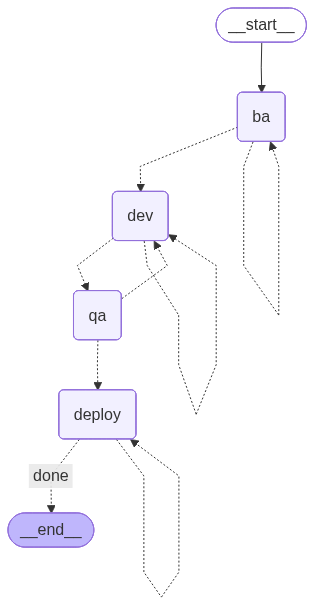

In [154]:
# visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

##### Initial BA prompt

In [165]:
state = initial_state
thread_id = "session-001"
#Run until the BA has asked the 3 clarifying questions (pause right after BA)
state = await app.ainvoke(
    state,
    config={"recursion_limit": 10, "thread_id": thread_id},
    interrupt_after=["ba"] #prevents infinite loops
    )

To clarify the requirements before drafting the PRD for the Todo app, I have a few questions:

Q1: What would you like to name the project? If you don't have a specific name in mind, I suggest "todo-app" — does that work for you?

Q2: What key features do you envision for the Todo app (e.g., task creation, due dates, categories, notifications)?

Q3: Who is the target audience for this Todo app, and are there any specific platforms (web, mobile) you want to focus on?


In [166]:
print(state["messages"][-1].content)

To clarify the requirements before drafting the PRD for the Todo app, I have a few questions:

Q1: What would you like to name the project? If you don't have a specific name in mind, I suggest "todo-app" — does that work for you?

Q2: What key features do you envision for the Todo app (e.g., task creation, due dates, categories, notifications)?

Q3: Who is the target audience for this Todo app, and are there any specific platforms (web, mobile) you want to focus on?


In [167]:
user_answer = """It is the begining of the year and I want a application that can help me track and improve my productivity. 
A planner app, where. 
I want to be able to add tasks with a description, a due date, and a priority weight.
I want to be able to delete tasks.
I want to be able to edit tasks.
I want to be able to view tasks.
I want to be able to prioritize tasks.
I want to be able to search tasks.
Also, able to define my new year resolutions at beginning of the year, 
monthly goals at the begining of the month, 
and daily goals at the beginning of the day.
I should also be able to see for example weekly progress, monthly progress, and yearly progress.

The app should provide a recommendation on how to course correct if I fall behind. And a calendar view that paints my tasks on the calendar. 
I should be able to drill down Montly , weekly, and daily tasks.
"""

state = await app.ainvoke(
    {"messages":[{"role":"user", "content":user_answer}]},
    config={"recursion_limit": 10, "thread_id": thread_id},
    )
print(state["messages"][-1].content)

{
  "project_name": "planner-app",
  "prd_path": "planner-app/business-documents/PRD.md",
  "prd_summary": [
    "Facilitates task management and tracking.",
    "Allows users to set yearly resolutions, monthly, and daily goals.",
    "Provides a calendar view for tasks with drill-down capabilities.",
    "Tracks weekly, monthly, and yearly progress.",
    "Offers recommendations for course correction."
  ]
}
The Product Requirements Document (PRD) for the "Planner App" has been successfully drafted. You can access it in the directory `sandbox/planner-app/business-documents/PRD.md`. If you need any further modifications or details, just let me know!
The Product Requirements Document (PRD) for the "Planner App" has been successfully drafted and saved. You can find it in the directory `sandbox/planner-app/business-documents/PRD.md`. If you need any additional changes or further assistance, feel free to ask!
The Product Requirements Document (PRD) for the "Planner App" has been successful

CancelledError: 

In [158]:
user_answer = """
For the name of app let's use "Productivity Planner" or a creative name
I am the primary target so the application is only for personal use. 
I want to be able to add tasks with a description, a due date, and a priority weight.
I want to be able to delete tasks.
I want to be able to edit tasks.
I want to be able to view tasks.
I want to be able to prioritize tasks.
I want to be able to search tasks.
Also, able to define my new year resolutions at beginning of the year, 
monthly goals at the begining of the month, 
and daily goals at the beginning of the day.
I should also be able to see for example weekly progress, monthly progress, and yearly progress.

The app should provide a recommendation on how to course correct if I fall behind. And a calendar view that paints my tasks on the calendar. 
I should be able to drill down Montly , weekly, and daily tasks.
For platform I want a web app that responds across all devices.
"""

await app.ainvoke(
    {"messages":[{"role":"user", "content":user_answer}]},
    config={"recursion_limit": 10, "thread_id": thread_id},
    interrupt_after=["ba"] #prevents infinite loops
    )
print(state["messages"][-1].content)

Q1: What would you like to name the project? If you don't have a name in mind, I suggest "todo-app". Shall we go with that?

Q2: What key features do you envision for the Todo app? (e.g., tasks creation, deadlines, categories)

Q3: Who is the target audience for this app, and what platforms should it be available on? (e.g., web, mobile)
